### In this Document I'll develop the code for testing strategies, based on the principles:
* Getting enoguh statistical significance  
* Neighbourhood testing
* Limitation of degrees of freedom 

### To do list: 
* Save our complete class in a doccument, and acces it just importing the class, the copy-paste procedure isn't efficient.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools 
import random
from itertools import product
from scipy.stats import linregress
from datetime import datetime
plt.style.use("seaborn")
pd.set_option("display.max_rows", None, "display.max_columns", None)#to display complete dataframe

In [2]:
#These spreads are from ic markets, and are overstimated by + 0.2 pips (0.000002 & for jpy related 0.002)
spread_dict = {"EURUSD":0.000082, "USDJPY":0.00940 , "USDCHF":0.0001  , "AUDUSD":0.000097, "GBPUSD":0.00013 , "EURJPY":0.015   , 
               "NZDUSD":0.000158, "AUDJPY":0.017   , "EURGBP":0.000147, "USDCAD":0.000105, "GBPNZD":0.00032 , "NZDCAD":0.000224,
               "GBPCAD":0.000232, "AUDCAD":0.000188, "EURNZD":0.000252, "AUDNZD":0.000197, "GBPAUD":0.000226, "NZDCHF":0.000193,
               "EURCAD":0.000194, "GBPCHF":0.00023 , "CADCHF":0.000178, "AUDCHF":0.000161, "EURCHF":0.000181, "CHFJPY":0.0206  ,
               "NZDJPY":0.018   , "EURAUD":0.0002  , "GBPJPY":0.0202  , "CADJPY":0.0168}

In [3]:
#FUNCTIONS. 
def rsi(dataframe, look_back):
    """The dataframe input must have a column named "Close" """
    
    df = dataframe.copy() #Copy of the original data
    close_prices = df.Close #save in "close_prices" the close prices
    
    #create the delta, which is the difference of the prices,.diff() substract the current value by the inmideatelly past value 
    delta = close_prices.diff()
    delta.dropna(inplace = True)
    
    #using .clip() function, with parameter lower = 0, we convert all the values below 0 into 0, in other words, 
    #we turn negative values into zero, doing this we only fill the up series with up periods. 
    up = delta.clip(lower = 0)
    
    #The same as with up, but only saving negative values and turning positives into 0; next multiply all values by -1 
    #to turn them into possitive ones. 
    down = -1 * delta.clip(upper = 0)
    
    #Let's calculate the exponential moving averages of up and down pandas series. 
    ema_up = up.ewm(span = look_back).mean()
    ema_down = down.ewm(span = look_back).mean()
    
    #Compute the rs, which is only the division between emas
    rs = ema_up/ema_down
    
    #Add the column rsi to the pandas dataframe we'll return. 
    df[f'rsi'] = 100 - (100 / (1 + rs))
    
    #remove nans
    df.dropna(inplace = True)
    
    
    return df


def ema(dataframe, look_back):
    
    df = dataframe.copy() #dataframe copy
    close = np.array(df.Close) #numpy array which contains close values
    ema = np.empty(len(df.Close)) #numpy array initialized with empty values (which doesent demand memory space)
    ema[0] = close[0] #store in the first position the Close price
    
    for i in range(1, len(df.Close)): #start the range from 1 instead 0
        ema[i] = ((close[i] - ema[i-1])*(2/(look_back+1))) + ema[i-1]
    
    df["ema"] = ema
    
    return df




def stochastic(dataframe, look_back):
    
    df = dataframe.copy()
    
    #Define the highest price"look_back" periods in the past
    df['highest'] = df.Close.rolling(look_back).max()
    
    #Define the lowest price"look_back" periods in the past
    df['lowest'] = df.Close.rolling(look_back).min()
    
    #Define the k percentage, which indicates where is located the previous close price with respect highest and lowest values, 
    #if this value is near 0, the close is near the lowest value & if near 1, the prevous close is near the highest. 
    df['k_pctg'] = ((df.Close - df.lowest)/(df.highest - df.lowest))*100
    
    #Define the moving average of 'k_pctg', usually this sma has period of 3. 
    df['k_sma'] = df.k_pctg.rolling(3).mean().round(decimals = 4)
    
    #remove 'highest' & 'lowest' columns cause they're not necesary for applying the indicator in predictive scenarios. 
    df.drop(['highest', 'lowest'], axis = 1, inplace = True)
    
    #remove null values
    df.dropna(inplace = True)
    
    return df


def sma(dataframe, look_back):
    df = dataframe.copy()
    df["sma"] = df.Close.rolling(look_back).mean()
    df = df.dropna()
    
    return df



def percentage_based_atr (dataframe, atr_bp):
    
    """
    This atr indicator is almost the same calculation as the conventional atr, but the ranges are not calculated with pips
    but with price percentage movements; this type of calculation let us compare volatility values between different markets,
    because the volatility calculation won't be in pips but in % of the price. 
    """  
    
    df = dataframe.copy()
    
    #following we compute the % moves dividing by the prices. here the Close.shift() represents the close price of the previous
    #period. 
    open_close_range = np.abs((df.Close - df.Open)/df.Open)
    open_range  = np.abs((df.Open - df.Close.shift())/df.Close.shift())
    close_range = np.abs((df.Close - df.Close.shift())/df.Close.shift())
    
    ranges = pd.concat([open_close_range, open_range, close_range], axis = 1)
    df["true_range"] = np.max(ranges, axis = 1)
    df[f"atr_{atr_bp}"] = df.true_range.rolling(atr_bp).mean()
    
    df = df.dropna()   
    
    return df


def atr_crossover (dataframe, short_bp, long_bp):
    
    """This indicator generates 2 moving averages (MA) based on the true range; the "atr_crossover" column indicates 1 when 
    the shorter MA is above the longest, and -1 when its the opposite. this indicator compares the recent volatility with the 
    long run volatility """  
    
    df = dataframe.copy()
    
    open_close_range = np.abs(df.Close - df.Open)
    open_range  = np.abs(df.Open - df.Close.shift())
    close_range = np.abs(df.Close - df.Close.shift())
    
    ranges = pd.concat([open_close_range, open_range, close_range], axis = 1)
    df["true_range"] = np.max(ranges, axis = 1)
    df["short_atr"] = df.true_range.rolling(short_bp).mean()
    df["long_atr"] = df.true_range.rolling(long_bp).mean()
    df["atr_crossover"] = np.where(df.short_atr >= df.long_atr, 1, -1)
    df = df.dropna()   
    
    return df    


def atr_percentage (dataframe, atr_bp, max_min_bp):
    
    """This filter indicates the percentage of the current atr compared with the maximum and minimum historical atr (max_min_bp)
    """  
    
    df = dataframe.copy()
    
    open_close_range = np.abs(df.Close - df.Open)
    open_range  = np.abs(df.Open - df.Close.shift())
    close_range = np.abs(df.Close - df.Close.shift())
    
    ranges = pd.concat([open_close_range, open_range, close_range], axis = 1)
    df["true_range"] = np.max(ranges, axis = 1)
    df["atr"] = df.true_range.rolling(atr_bp).mean()
    df["max_atr"] = df.atr.rolling(max_min_bp).max()
    df["min_atr"] = df.atr.rolling(max_min_bp).min()
    df["atr_percentage"] = (((df.atr-df.min_atr)/(df.max_atr-df.min_atr))*100).round(3)
    
    df = df.dropna()   
    
    return df   

def up_down (dataframe, look_back):
    
    """This function generates a dataframe with an indicator, which tells how many up or down periods have occured in the past. 
    using the parameter look_back; beeing 1 for an up period and -1 for a down period; for example if the look back is 4 and 
    have occurred 4 down periods in the past, this indicator will be -4""" 
    
    df = dataframe.copy()
    df["differences"] = df.Close - df.Close.shift(1)
    df = df.dropna()
    df["sign"] = np.sign(df.differences)
    df["sum_up_down"] = df.sign.rolling(look_back).sum()
    df = df.dropna()
    df.drop(["differences", "sign"], axis = 1, inplace = True)
    
    return df

def momentum_sign (dataframe, look_back):
    
    """The momentum_sign indicator, tells -1 if the current Close price is below than the Close price n periods back (look_back), 
    and tells 1 if the current close price is above the close price n periods back"""
        
    df = dataframe.copy()
    df["momentum_sign"] = np.where(df.Close > df.Close.shift(look_back), 1, -1)
    df = df.dropna()
    
    return df

def sma_envelop (dataframe, sma_period, envelop_pips):
    
    df = dataframe.copy()
    df["sma"] = df.Close.rolling(sma_period).mean()
    df = df.dropna()
    df["sma_upper"] = df.sma + envelop_pips
    df["sma_lower"] = df.sma - envelop_pips
    
    return df 

In [5]:
class simple_optimizer():
    
    def __init__(self, file_name, start, end, timeframe, tc,  p1 = None, p2 = None, p3 = None):#Here we call all the data we're gonna work from the symbol to the 
        self.file_name = file_name #date range.  
           
        self.p1 = p1 #Bars since entry
        
        self.p2 = p2 
        
        self.p3 = p3 
        
        self.start = start#If we want to perform wf analysis, we should initialize the class with the first start in  
        self.end = end                                            #sample date, but with enough data to compute indicators.
        self.timeframe = timeframe
        self.tc = tc #transaction costs in pips (0.0001 notation)
        self.results = None #the self.results dataframe will be "None" until we call self.test_strategy() method
        self.get_data() #When the class is initialized, methods get_data() & prepare_data() are called inmediatelly
        self.prepare_data()

        ###################################### Trading Costs and pip value #################################################
        
        if ("JPY" in self.file_name ):
            self.pip_value = 0.01
            
        else:
            self.pip_value = 0.0001
        
    def get_data(self):
        custom_date_parser = lambda x: datetime.strptime(x, "%d.%m.%Y %H:%M:%S.%f") #this function is a parser, this tells python how to recognize the datetime format we have in the csvfile from dukascopy
        raw = pd.read_csv(self.file_name, parse_dates = ["Gmttime"], date_parser=custom_date_parser, index_col = "Gmttime")
        raw = raw[["Open", "Close"]].dropna()              
        raw = raw.loc[self.start:self.end].copy() #We make a copy from the orininal imported df, and slice our date period
        self.data = raw
    
    #MAYBE THIS METHOD IS NOT USEFULL ANYMORE, BECAUSE WE ALWAYS NEED TO RE-CALCULATE INDICATORS BECAUSE WE CHANGE PARAMETERS.
    def prepare_data(self): #Here we compute indicators which should be computed only once. 
        data = self.data.copy() #Make a copy from the df produced previouslly in self.get_data() method. 
        self.data = data
        
        
        
        
    def set_parameters(self, p1 = None, p2 = None, p3 = None):
        
        #en este paso, si vamos a calcular un indicador, necesitamos crear una nueva database, si no lo hacemos, generamos un 
        #error !!!!, en este caso, como ejemplo, generamos la database llamada "self.data_prepared", esto debe ser así porque 
        #al momento de optimizar, si no creamos una database diferente a "self.data", lo que haríamos sería sobreescribir esta
        #muchas veces y esto genera un error. 
        
        if p1 is not None:
            self.p1 = p1
            
        if p2 is not None: 
            self.p2 = p2 
            #IT COULD BE POSSIBLE THAT WE CAN COMPUTE THE INDICATORS INSIDE THE "test_strategy", TEST IF THIS IS POSSIBLE 
            #COMPARING THE RESOULTS WITH THE "Optimizador Alternativo"
            #self.data_prepared = self.data
            #self.data_prepared = sma_envelop(dataframe = self.data, sma_period = self.p2, envelop_pips = self.pip_value*20)
            
        if p3 is not None:
            self.p3 = p3
            
            

            
            
            
            
    def test_strategy(self, start_test, end_test): #These parameters give us the possibility to perform a test in a determinated
        self.start_test = start_test               #range of time, without losing data computing sma or any other indicators.
        self.end_test = end_test
        
        #---------------------------------------------------------------------------
        #Here if we want to compute an indicator
        #In this case, compute an sma of n periods
        self.data_prepared = sma(self.data, 5) #This self.data is the 'dataframe' from 'prepare_data()' method, this dataframe
                                                #is diferent to the 'data' dataframe we generate below, which is a new one. 
        #---------------------------------------------------------------------------
        
        #---------------------------------------------------------------------------
        #THIS IS AN IMPORTANT STEP --> self.data_prepared is needed to avoid errors. 
        data = self.data_prepared.copy().dropna() 
        #---------------------------------------------------------------------------
        
        data = data.loc[self.start_test:self.end_test] #Cut the complete dataframe in the slice we want, after compute indicators 
        data["hour"] = data.index.hour
        
        #---------------------------------------------------------------------------
        #This parameter controls the # of bars we wait to close a trade
        bars_since_entry = self.p1 #parameter
        #---------------------------------------------------------------------------

#//////////////////////////////////////////////// STRATEGY CORE //////////////////////////////////////////////////////////////

        position = [0] * len(data.Close) #This is the list which indicates whether we are in a buy (1) or sell (-1) position
        self.trades = []                 #list which indicates the result of every trade
        self.trades_dates = []           #list which stores the date of every trade
        entry_index = 0
        entry_price = 0

        for j in range (1, len(data.Close)):
            
        #ENTRY SECTION 
            
            #Buy entry
            
            # if the previous position is zero (we are not in a trade), analyze whether we need to buy or sell or nothing. 
            if(position[j-1] == 0): 
                
                #if(data.Open[j] > data.sma[j-1]): #above
                if(data.Open[j] < data.sma[j-1]): #below 
    
                    if((((data.Close[j-1]-data.Open[j-1])/data.Open[j-1])*100) > self.p2/100):
                    #if((((data.Close[j-1]-data.Open[j-1])/data.Open[j-1])*100) < -self.p2/100):#Counter trend strategy

                        position[j] = 1
                        entry_index = j
                        entry_price = data.Open[j]
                    
            
            #Sell entry 
                #if(data.Open[j] < data.sma[j-1]): #below
                if(data.Open[j] > data.sma[j-1]): #above
                    
                    if((((data.Close[j-1]-data.Open[j-1])/data.Open[j-1])*100) < -self.p2/100):
                    #if((((data.Close[j-1]-data.Open[j-1])/data.Open[j-1])*100) > self.p2/100): #Counter trend strategy

                        position[j] = -1
                        entry_index = j
                        entry_price = data.Open[j]
            
            
        #EXIT SECTION
            
            #BUY EXIT ------
            
            #if the position is 1 and the current index 'j' is less than the entry_index + bars_since_entry (# of bars we wait
            #until we close the trade) keep filling the 'position' list with 1, so we keep the trade
            
            if ((position [j-1] == 1) & (j < (entry_index + bars_since_entry))):

                position[j] = 1
                
            #if the current index 'j' equals the entry_index + bars_since_entry (# of bars we wait until we close the trade)
            #and the position we had in the past candle was 1, so we exit the trade
                
            if ((j == (entry_index + bars_since_entry)) & (position[j-1] == 1)):
                
                self.trades.append((data.Open[j] - entry_price)) #Multiply by -1 if its a sell
                self.trades_dates.append(data.index[j])
                
                
            #SELL EXIT ------
            
            #if the position is -1 and the current index 'j' is less than the entry_index + bars_since_entry (# of bars we wait
            #until we close the trade) keep filling the 'position' list with -1, so we keep the trade
            
            if ((position [j-1] == -1) & (j < (entry_index + bars_since_entry))):

                position[j] = -1
            
            #if the current index 'j' equals the entry_index + bars_since_entry (# of bars we wait until we close the trade)
            #and the position we had in the past candle was -1, so we exit the trade
                
            if ((j == (entry_index + bars_since_entry)) & (position[j-1] == -1)):

                self.trades.append((data.Open[j] - entry_price)*-1) #Multiply by -1 if its a sell
                self.trades_dates.append(data.index[j])
                
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

        self.trades #list which saves all the trades. 
        data["position"] = position
        data.dropna(inplace=True)
        self.results = data #dataframe which contains test results
        
        #TRADING COSTS           
        self.trades_w_costs = [w - self.tc for w in self.trades]#add trading costs       
                       
        #Strategy's performance
        if len(self.trades) > 0: #if there are more than 1 trade
            perf = np.cumsum(self.trades_w_costs)[-1] # absolute performance of the strategy
        else:
            perf = -1000
        
        return round(perf, 6)
    
    
    
    
    
    
    
        
    def optimize_parameters(self, opt_start, opt_end, param_1_range = None, param_2_range = None, param_3_range = None):
        self.opt_start = opt_start
        self.opt_end = opt_end     
        
        #param_1_range & param_2_range are tupples -simple arrays of three components- where the first is the start range,the second is the last range member & last is the pase or step
        #using * we can pass the tupples to the range function, if we don't use * we get an error because range function need 3 parameters, * "Unpacks" the tupple.
        
        if ((self.p1 != None) & (self.p2 == None) & (self.p3 == None)):
            combinations = list(range(*param_1_range)) #range function does not support floats, be careful
            self.results_profit = []      
            self.performance_index_for_every_combination = []
            self.trades_of_every_combination = []#List which will save the trades for every combination
            self.complete_dataframe_of_every_test = [] #list which contains the dataframe of every test round
            for comb in combinations: 
                self.set_parameters(comb)
                self.results_profit.append(self.test_strategy(start_test = self.opt_start, end_test = self.opt_end))
                #Here we pass the list of trades to the Method which calculates the performance index, with this procedure, we 
                #get the performance index for every combination of parameters
                self.performance_index_for_every_combination.append(self.performance_index(self.trades_w_costs))
                self.trades_of_every_combination.append(self.trades_w_costs)
                self.complete_dataframe_of_every_test.append(self.results)
                
            
        
        if ((self.p1 != None) & (self.p2 != None) & (self.p3 == None)):      
            combinations = list(product(range(*param_1_range), range(*param_2_range)))#range function does not support floats, be careful
            self.results_profit = [] 
            self.performance_index_for_every_combination = []
            self.trades_of_every_combination = []#List which will save the trades for every combination
            self.complete_dataframe_of_every_test = [] #list which contains the dataframe of every test round
            for comb in combinations: 
                self.set_parameters(comb[0], comb[1])
                self.results_profit.append(self.test_strategy(start_test = self.opt_start, end_test = self.opt_end))
                #Here we pass the list of trades to the Method which calculates the performance index, with this procedure, we 
                #get the performance index for every combination of parameters
                self.performance_index_for_every_combination.append(self.performance_index(self.trades_w_costs))
                self.trades_of_every_combination.append(self.trades_w_costs)
                self.complete_dataframe_of_every_test.append(self.results)
                
                
        if ((self.p1 != None) & (self.p2 != None) & (self.p3 != None)):      
            combinations = list(product(range(*param_1_range), range(*param_2_range), range(*param_3_range)))#range function does not support floats, be careful
            self.results_profit = []  
            self.performance_index_for_every_combination = []
            self.trades_of_every_combination = []#List which will save the trades for every combination
            self.complete_dataframe_of_every_test = [] #list which contains the dataframe of every test round
            for comb in combinations: 
                self.set_parameters(comb[0], comb[1], comb[2])
                self.results_profit.append(self.test_strategy(start_test = self.opt_start, end_test = self.opt_end))
                #Here we pass the list of trades to the Method which calculates the performance index, with this procedure, we 
                #get the performance index for every combination of parameters
                self.performance_index_for_every_combination.append(self.performance_index(self.trades_w_costs))
                self.trades_of_every_combination.append(self.trades_w_costs)
                self.complete_dataframe_of_every_test.append(self.results)
        
        
        
        self.best_index = np.min(self.performance_index_for_every_combination)#Saves the lowest index value. 
        #tota profit of the combination with lowest performance index
        self.best_perf = self.results_profit[np.argmin(self.performance_index_for_every_combination)]
        #optimal parameters, np.argmin() gives me the index of the lowest value in the list which contains the indexes, and with 
        #this index i can call from the list 'combinations' the parameters with the lowest performance index.
        self.opt = combinations[np.argmin(self.performance_index_for_every_combination)] 
        self.trades_of_the_combination_with_lowest_index = self.trades_of_every_combination[np.argmin(self.performance_index_for_every_combination)]
        self.complete_dataframe_of_the_combination_with_lowest_index = self.complete_dataframe_of_every_test[np.argmin(self.performance_index_for_every_combination)]
                                               
        
        #Generate a dataframe which returns the performance of every combination of parameters. 
        self.df_param_perf = pd.DataFrame({'parameters':combinations, 'performance':self.results_profit, 
                                          'performance_index':self.performance_index_for_every_combination})
        
        #Calculate % of profitable combinations
        self.pctg_profitable = ((len([i for i in self.results_profit if i>0]))/len(self.results_profit))*100

        return self.opt, round(self.best_index, 2), round(self.best_perf, 2), round(self.pctg_profitable, 2), len(self.trades_of_the_combination_with_lowest_index)
    
    
    
    
    
    
    
    
    def walk_forward (self, wf_param_1_range = None, wf_param_2_range = None, wf_param_3_range = None):
        
        if (self.timeframe == "4h"):
            
            is_start_dates = ["2008-01-01", "2011-01-01", "2014-01-01"]
            is_end_dates   = ["2011-12-31", "2014-12-31", "2017-12-31"]       
            os_start_dates = ["2012-01-01", "2015-01-01", "2018-01-01"]
            os_end_dates   = ["2014-12-31", "2017-12-31", "2020-12-31"]
            wf_date_ranges = ["2012-2014", "2015-2017", "2018-2020"]        
        
        if (self.timeframe == "1h"):
        
            is_start_dates = ["2011-01-01", "2013-01-01", "2015-01-01", "2017-01-01"]
            is_end_dates   = ["2012-12-31", "2014-12-31", "2016-12-31", "2018-12-31"]       
            os_start_dates = ["2013-01-01", "2015-01-01", "2017-01-01", "2019-01-01"]
            os_end_dates   = ["2014-12-31", "2016-12-31", "2018-12-31", "2020-12-31"]
            wf_date_ranges = ["2013-2014", "2015-2016", "2017-2018", "2019-2020"]
            
        if (self.timeframe == "30m"):
        
            is_start_dates = ["2013-01-01", "2015-01-01", "2017-01-01"]
            is_end_dates   = ["2014-12-31", "2016-12-31", "2018-12-31"]       
            os_start_dates = ["2015-01-01", "2017-01-01", "2019-01-01"]
            os_end_dates   = ["2016-12-31", "2018-12-31", "2020-12-31"]
            wf_date_ranges = ["2015-2016", "2017-2018", "2019-2020"]
            
        if (self.timeframe == "15m"):
            
            is_start_dates = ["2014-01-01", "2016-01-01", "2018-01-01"]
            is_end_dates   = ["2014-12-31", "2016-12-31", "2018-12-31"]       
            os_start_dates = ["2015-01-01", "2017-01-01", "2019-01-01"]
            os_end_dates   = ["2016-12-31", "2018-12-31", "2020-12-31"]
            wf_date_ranges = ["2015-2016", "2017-2018", "2019-2020"]
         
        if (self.timeframe == "5m"):
            
            is_start_dates = ["2014-01-01", "2016-01-01", "2018-01-01"]
            is_end_dates   = ["2014-12-31", "2016-12-31", "2018-12-31"]       
            os_start_dates = ["2015-01-01", "2017-01-01", "2019-01-01"]
            os_end_dates   = ["2016-12-31", "2018-12-31", "2020-12-31"]
            wf_date_ranges = ["2015-2016", "2017-2018", "2019-2020"]
            
        
        self.wf_opt_parameters = []
        wf_performance = []
             
        if ((self.p1 != None) & (self.p2 == None) & (self.p3 == None)):
            for i in range (len(is_start_dates)):
                self.optimize_parameters(is_start_dates[i], is_end_dates[i], wf_param_1_range)
                self.wf_opt_parameters.append(self.opt)                                                                                      
                wf_performance.append(self.best_perf)
                
        if ((self.p1 != None) & (self.p2 != None) & (self.p3 == None)): 
            for i in range (len(is_start_dates)):
                self.optimize_parameters(is_start_dates[i],is_end_dates[i], wf_param_1_range, wf_param_2_range)
                self.wf_opt_parameters.append(self.opt)                                                                                      
                wf_performance.append(self.best_perf)
                
        if ((self.p1 != None) & (self.p2 != None) & (self.p3 != None)):
            for i in range (len(is_start_dates)):
                self.optimize_parameters(is_start_dates[i],is_end_dates[i], wf_param_1_range, wf_param_2_range,
                                                                                                         wf_param_3_range)
                self.wf_opt_parameters.append(self.opt)                                                                                      
                wf_performance.append(self.best_perf)
                
                
        if ((self.p1 != None) & (self.p2 == None) & (self.p3 == None)): 
            self.wf_opt_parameters = pd.DataFrame (data = self.wf_opt_parameters, columns = ["param_1"])
            
        if ((self.p1 != None) & (self.p2 != None) & (self.p3 == None)): 
            self.wf_opt_parameters = pd.DataFrame (data = self.wf_opt_parameters, columns = ["param_1", "param_2"])
            
        if ((self.p1 != None) & (self.p2 != None) & (self.p3 != None)):
            self.wf_opt_parameters = pd.DataFrame (data = self.wf_opt_parameters, columns = ["param_1", "param_2",
                                                                                                        "param_3"])

        self.wf_opt_parameters ["dates"] = wf_date_ranges
        self.wf_opt_parameters = self.wf_opt_parameters.set_index("dates")
        self.wf_opt_parameters ["performance"] = wf_performance 
        
        
        performance_os = [] #Contains the absolute performance of the out of sample periods
        list_of_total_trades = [] #list of lists.
        list_of_df_results = [] #contains the four pd dataframes we get for each test, this is a list which contains 
                                                                                                          #dataframes ¡WTF! xD
        
        if ((self.p1 != None) & (self.p2 == None) & (self.p3 == None)):
            for i in range (len(is_start_dates)):
                self.set_parameters(self.wf_opt_parameters.param_1[i])
                performance_os.append(self.test_strategy(start_test = os_start_dates[i], end_test = os_end_dates[i]))
                list_of_total_trades.append(self.trades)
                list_of_df_results.append(self.results)
        
        if ((self.p1 != None) & (self.p2 != None) & (self.p3 == None)):
            for i in range (len(is_start_dates)):
                self.set_parameters(self.wf_opt_parameters.param_1[i], self.wf_opt_parameters.param_2[i])
                performance_os.append(self.test_strategy(start_test = os_start_dates[i], end_test = os_end_dates[i]))
                list_of_total_trades.append(self.trades)
                list_of_df_results.append(self.results)
        
        if ((self.p1 != None) & (self.p2 != None) & (self.p3 != None)):
            for i in range (len(is_start_dates)):
                self.set_parameters(self.wf_opt_parameters.param_1[i], self.wf_opt_parameters.param_2[i],
                                                                                       self.wf_opt_parameters.param_3[i])
                performance_os.append(self.test_strategy(start_test = os_start_dates[i], end_test = os_end_dates[i]))
                list_of_total_trades.append(self.trades)
                list_of_df_results.append(self.results)
        
        self.df_complete = pd.concat(list_of_df_results) #Here we joint the dataframes generated containing the resoults of the out of sample periods  
        
        self.total_trades=[]
        for i in list_of_total_trades: #with these fors we joint the list of lists into one only list named self.total_trades
            for j in i:
                self.total_trades.append(j)
        
        self.total_trades_with_costs = [w - self.tc for w in self.total_trades] # add trading costs  
         
    #--------------------------------------------------------------------------------------------------------------------------
        if len(self.total_trades_with_costs) > 0: #if there are more than 1 trade
            
            ###################################### Calculate profit factor ##############################################
        
            pos = [w for w in self.total_trades_with_costs if w > 0]
            neg = [w for w in self.total_trades_with_costs if w < 0]

            gain = np.sum(pos)
            lost = abs(np.sum(neg))

            self.inversed_pf = round (lost/gain, 3) #inversed profit factor

            ###################################### Calculate slope and r^2 ##############################################

            trend = linregress (range(0,len(self.total_trades_with_costs), 1), np.cumsum(self.total_trades_with_costs))

            self.slope = trend.slope       #slope of the equity curve
            self.r_sqrt = trend.rvalue**2  #r^2 of the linear regression

            #################################### Calculate profitable index #############################################

            self.index = (self.inversed_pf / self.r_sqrt) #This index must be less than 1 to be profitable and the less the better

            #############################################################################################################
            
        else:
            self.index = 10000
        
        
        
        return self.total_trades
    
    
    
    
    
    
    
    def performance_index(self, trades):
        
        if len(trades) > 0: #if there are more than 1 trade
            
            ###################################### Calculate profit factor ##############################################
        
            pos = [w for w in trades if w > 0]
            neg = [w for w in trades if w < 0]

            gain = np.sum(pos)
            lost = abs(np.sum(neg))

            self.inversed_pf = round (lost/gain, 3) #inversed profit factor

            ###################################### Calculate slope and r^2 ##############################################

            trend = linregress(range(0,len(trades), 1), np.cumsum(trades))

            self.slope = trend.slope       #slope of the equity curve
            self.r_sqrt = trend.rvalue**2  #r^2 of the linear regression

            #################################### Calculate profitable index #############################################

            self.index = (self.inversed_pf / self.r_sqrt) #This index must be less than 1 to be profitable and the less the better

            #############################################################################################################
            
        else:
            self.index = 10000
            
        return self.index

In [6]:
import time
start_time = time.time()

#These spreads are from ic markets, and are overstimated by + 0.2 pips (0.000002 & for jpy related 0.002)
spread_dict = {"EURUSD":0.000082, "USDJPY":0.00940 , "USDCHF":0.0001  , "AUDUSD":0.000097, "GBPUSD":0.00013 , "EURJPY":0.015   , 
               "NZDUSD":0.000158, "AUDJPY":0.017   , "EURGBP":0.000147, "USDCAD":0.000105, "GBPNZD":0.00032 , "NZDCAD":0.000224,
               "GBPCAD":0.000232, "AUDCAD":0.000188, "EURNZD":0.000252, "AUDNZD":0.000197, "GBPAUD":0.000226, "NZDCHF":0.000193,
               "EURCAD":0.000194, "GBPCHF":0.00023 , "CADCHF":0.000178, "AUDCHF":0.000161, "EURCHF":0.000181, "CHFJPY":0.0206  ,
               "NZDJPY":0.018   , "EURAUD":0.0002  , "GBPJPY":0.0202  , "CADJPY":0.0168}

list_of_markets = list(spread_dict.keys())
database_names = []
best_parameters_list = []
performance_indexes_list = []
profits_list = []
percentage_of_profitable_combinations_list = []
number_of_trades_list = []
trades_of_the_best_comb_of_parameters_list = []
complete_dataframes = [] #This list saves the complete dataframe for every tested parameter combination



      
#4h----------------------------------------------------------------------------------------------------
for j in spread_dict.keys():

    testing = simple_optimizer(f'{j}_4h_BID_EET_GMT.csv', "2005-01-01", "2020-12-31", "4h", spread_dict[j], 30, 5)
    
    #Create the optimizator
    optimization_resoults = testing.optimize_parameters("2005-01-01", "2020-12-31", (1,3,1), (30, 60, 10))
    
    database_names.append(f'{j}_4h_BID_EET_GMT.csv')
    best_parameters_list.append(optimization_resoults[0])
    performance_indexes_list.append(optimization_resoults[1])
    profits_list.append(optimization_resoults[2])
    percentage_of_profitable_combinations_list.append(optimization_resoults[3])
    number_of_trades_list.append(optimization_resoults[4])
    trades_of_the_best_comb_of_parameters_list.append(testing.trades_of_the_combination_with_lowest_index)
    complete_dataframes.append(testing.complete_dataframe_of_the_combination_with_lowest_index)
      


#1h----------------------------------------------------------------------------------------------------
for j in spread_dict.keys():

    testing = simple_optimizer(f'{j}_1h_BID_EET_GMT.csv', "2008-01-01", "2020-12-31", "1h", spread_dict[j], 30, 5)
    
    #Create the optimizator
    optimization_resoults = testing.optimize_parameters("2005-01-01", "2020-12-31", (1,3,1), (15, 45, 10))
    
    database_names.append(f'{j}_1h_BID_EET_GMT.csv')
    best_parameters_list.append(optimization_resoults[0])
    performance_indexes_list.append(optimization_resoults[1])
    profits_list.append(optimization_resoults[2])
    percentage_of_profitable_combinations_list.append(optimization_resoults[3])
    number_of_trades_list.append(optimization_resoults[4])
    trades_of_the_best_comb_of_parameters_list.append(testing.trades_of_the_combination_with_lowest_index)
    
    complete_dataframes.append(testing.complete_dataframe_of_the_combination_with_lowest_index)

"""
    
#30m----------------------------------------------------------------------------------------------------

#for j in spread_dict.keys():
for j in list_of_markets[15:29]:

    testing = simple_optimizer(f'{j}_30m_BID_EET_GMT.csv', "2010-01-01", "2020-12-31", "30m", spread_dict[j], 30, 5)
    
    #Create the optimizator
    optimization_resoults = testing.optimize_parameters("2005-01-01", "2020-12-31", (12,28,4), (15, 35, 5))
    
    database_names.append(f'{j}_30m_BID_EET_GMT.csv')
    best_parameters_list.append(optimization_resoults[0])
    performance_indexes_list.append(optimization_resoults[1])
    profits_list.append(optimization_resoults[2])
    percentage_of_profitable_combinations_list.append(optimization_resoults[3])
    number_of_trades_list.append(optimization_resoults[4])
    trades_of_the_best_comb_of_parameters_list.append(testing.trades_of_the_combination_with_lowest_index)
    
    complete_dataframes.append(testing.complete_dataframe_of_the_combination_with_lowest_index)




#15m----------------------------------------------------------------------------------------------------

#for j in spread_dict.keys():
for j in list_of_markets[20:29]:

    testing = simple_optimizer(f'{j}_15m_BID_EET_GMT.csv', "2010-01-01", "2020-12-31", "15m", spread_dict[j], 30, 5)
    
    #Create the optimizator
    optimization_resoults = testing.optimize_parameters("2005-01-01", "2020-12-31", (20, 68, 12), (12, 24, 4))
    
    database_names.append(f'{j}_15m_BID_EET_GMT.csv')
    best_parameters_list.append(optimization_resoults[0])
    performance_indexes_list.append(optimization_resoults[1])
    profits_list.append(optimization_resoults[2])
    percentage_of_profitable_combinations_list.append(optimization_resoults[3])
    number_of_trades_list.append(optimization_resoults[4])
    trades_of_the_best_comb_of_parameters_list.append(testing.trades_of_the_combination_with_lowest_index)
    
    complete_dataframes.append(testing.complete_dataframe_of_the_combination_with_lowest_index)




#5m----------------------------------------------------------------------------------------------------

#for j in spread_dict.keys():
for j in list_of_markets[0:11]:

    testing = simple_optimizer(f'{j}_5m_BID_EET_GMT.csv', "2010-01-01", "2020-12-31", "5m", spread_dict[j], 30, 5)
    
    #Create the optimizator
    optimization_resoults = testing.optimize_parameters("2005-01-01", "2020-12-31", (48,120,24), (5, 9, 1))
    
    database_names.append(f'{j}_5m_BID_EET_GMT.csv')
    best_parameters_list.append(optimization_resoults[0])
    performance_indexes_list.append(optimization_resoults[1])
    profits_list.append(optimization_resoults[2])
    percentage_of_profitable_combinations_list.append(optimization_resoults[3])
    number_of_trades_list.append(optimization_resoults[4])
    trades_of_the_best_comb_of_parameters_list.append(testing.trades_of_the_combination_with_lowest_index)
    
    complete_dataframes.append(testing.complete_dataframe_of_the_combination_with_lowest_index)
    
"""

print("--- %s seconds ---" % (time.time() - start_time))

--- 4468.400942325592 seconds ---


In [7]:
#Generating the Dataframe which will output all the optmization resoults
optimization_resoults_df = pd.DataFrame({'databases':database_names, 
                                      'parameter combination':best_parameters_list,
                                      'performance_index':performance_indexes_list,
                                      'profit_pips':profits_list,
                                      '% profitable combinations':percentage_of_profitable_combinations_list,
                                      'trades quantity:':number_of_trades_list,
                                      'row number':range(0, len(database_names),1)
                                     })

In [8]:
optimization_resoults_df

,databases,parameter combination,performance_index,profit_pips,% profitable combinations,trades quantity:,row number
0,EURUSD_4h_BID_EET_GMT.csv,"(2, 40)",0.84,0.05,100.00,71,0
1,USDJPY_4h_BID_EET_GMT.csv,"(1, 30)",2.27,-5.40,16.67,226,1
2,USDCHF_4h_BID_EET_GMT.csv,"(1, 30)",0.97,0.08,66.67,208,2
3,AUDUSD_4h_BID_EET_GMT.csv,"(2, 30)",1.58,-0.10,16.67,386,3
4,GBPUSD_4h_BID_EET_GMT.csv,"(2, 40)",0.44,0.25,100.00,80,4
5,EURJPY_4h_BID_EET_GMT.csv,"(2, 50)",0.80,12.34,50.00,93,5
6,NZDUSD_4h_BID_EET_GMT.csv,"(1, 30)",1.44,-0.12,33.33,498,6
7,AUDJPY_4h_BID_EET_GMT.csv,"(2, 50)",1.06,16.01,16.67,237,7
8,EURGBP_4h_BID_EET_GMT.csv,"(2, 30)",1.72,-0.08,0.00,146,8
9,USDCAD_4h_BID_EET_GMT.csv,"(2, 30)",1.79,-0.06,33.33,211,9


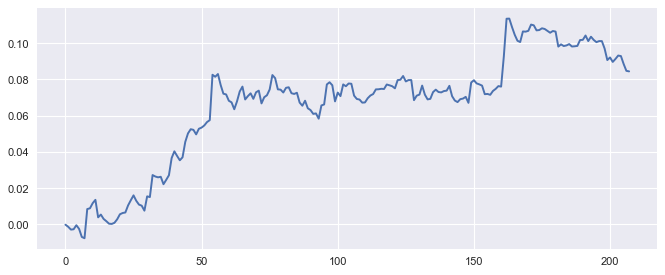

In [9]:
#Plotting some intersting strategy. 
from matplotlib.pyplot import figure
figure(figsize=(10, 4), dpi=80)
plt.plot(np.cumsum(trades_of_the_best_comb_of_parameters_list[2]))
plt.show;

In [10]:
trades_of_the_best_comb_of_parameters_list[18][0:5]

[0.00039600000000009045,
 0.000246000000000218,
 0.0012559999999999514,
 -0.00477400000000025,
 -0.00681400000000007]

In [11]:
complete_dataframes[18].iloc[0:1000]

,Open,Close,sma,hour,position
Gmttime,,,,,
2005-01-03 14:00:00,1.62926,1.63042,1.629092,14,0
2005-01-03 18:00:00,1.63043,1.62552,1.628412,18,0
2005-01-03 22:00:00,1.62552,1.62681,1.628348,22,0
2005-01-04 02:00:00,1.62681,1.62784,1.627994,2,0
2005-01-04 06:00:00,1.62784,1.62116,1.626350,6,0
2005-01-04 10:00:00,1.62128,1.62202,1.624670,10,0
2005-01-04 14:00:00,1.62202,1.62365,1.624296,14,0
2005-01-04 18:00:00,1.62365,1.62536,1.624006,18,0
2005-01-04 22:00:00,1.62536,1.62216,1.622870,22,0


# CODE FOR TESTING 1 PARAMETER COMBINATION, WITH THIS WE CAN VALIDATE IF THE CODE IS CORRECT

In [19]:
currency = 'EURNZD'
timeframe = "4h"

testing = simple_optimizer(f'{currency}_{timeframe}_BID_EET_GMT.csv', "2005-01-01", "2020-12-31", f"{timeframe}", spread_dict[f'{currency}'], 30, 5)
testing.set_parameters(4, 40)
testing.test_strategy("2005-01-01", "2020-12-31")

-0.392346

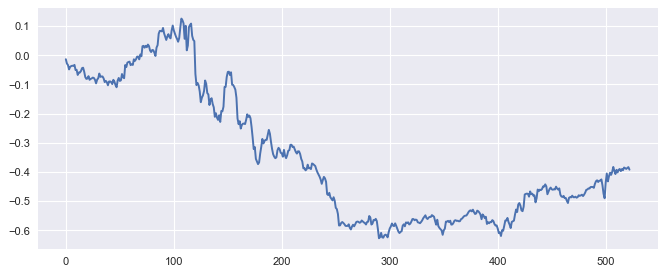

In [20]:
#Plotting some intersting strategy. 
from matplotlib.pyplot import figure
figure(figsize=(10, 4), dpi=80)
plt.plot(np.cumsum(testing.trades_w_costs))
plt.show;

In [21]:
testing.trades_w_costs[0:10]

[-0.013641999999999791,
 -0.014682000000000165,
 -0.005392000000000144,
 -0.014801999999999841,
 0.008657999999999973,
 0.002777999999999866,
 0.0011979999999999513,
 -0.00043199999999984695,
 0.003197999999999953,
 -0.017601999999999975]

In [22]:
testing.results.iloc[0:1000]

,Open,Close,sma,hour,position
Gmttime,,,,,
2006-01-06 02:00:00,1.76136,1.76401,1.755801,2,0
2006-01-06 06:00:00,1.76403,1.76650,1.757168,6,0
2006-01-06 10:00:00,1.76654,1.76674,1.758700,10,0
2006-01-06 14:00:00,1.76681,1.75584,1.759451,14,0
2006-01-06 18:00:00,1.75586,1.75570,1.760211,18,0
2006-01-08 22:00:00,1.75500,1.75324,1.760187,22,0
2006-01-09 02:00:00,1.75334,1.75112,1.759799,2,0
2006-01-09 06:00:00,1.75074,1.74518,1.759178,6,0
2006-01-09 10:00:00,1.74507,1.74677,1.758585,10,0


# Optimize just for only one market and one parameter space

In [ ]:
import time
start_time = time.time()

currency = 'EURNZD'
timeframe = '1h'

testing = simple_optimizer(f'{currency}_{timeframe}_BID_EET_GMT.csv', "2005-01-01", "2020-12-31", f'{timeframe}', 
                           spread_dict[f'{currency}'], 30, 5)

optimization_resoults = testing.optimize_parameters("2005-01-01", "2020-12-31", (5,13,2), (22, 43, 7))


print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
testing.df_param_perf

In [ ]:
#BAR CHART OF THE DISTRIBUTION FOR ONE PARAMETER SPACE. 
from matplotlib.pyplot import figure
figure(figsize=(10, 4), dpi=80)
plt.bar(range(0,len(testing.df_param_perf.performance),1),testing.df_param_perf.performance)
plt.show;

In [ ]:
#Plotting some intersting strategy. 
from matplotlib.pyplot import figure
figure(figsize=(10, 4), dpi=80)
plt.plot(np.cumsum(testing.trades_of_the_combination_with_lowest_index))
plt.show

# ADITIONAL TESTS (LIMITED TESTS)

# Optimizador Alternativo
El siguiente código hace exactamente lo mismo que el método "optimize_parameters" de la clase "simple_optimizer", pero usando este código podemos comparar los resultados de los dos métodos y así certificar que están haciendo lo indicado. 

In [23]:
#Cargar datos 

currency = 'EURNZD'
timeframe = '4h'

custom_date_parser = lambda x: datetime.strptime(x, "%d.%m.%Y %H:%M:%S.%f") #this function is a parser, this tells python how to recognize the datetime format we have in the csvfile from dukascopy
raw = pd.read_csv(f"{currency}_{timeframe}_BID_EET_GMT.csv", parse_dates = ["Gmttime"], date_parser=custom_date_parser, index_col = "Gmttime")
raw = raw[["Open", "Close"]].dropna()              
raw = raw.loc["2005-01-01":"2020-12-31"].copy() #We make a copy from the orininal imported df, and slice our date period

parameter1 = [] #Lista que almacena el valor del parametro 1 en la iteración actual. 
parameter2 = [] #Lista que almacena el valor del parametro 2 en la iteración actual. 
performance_combination = [] #Lista que almacena el desempeño de la estrategia para cada combinación de parámetros. 
tc = spread_dict[f'{currency}']

#If we don't need a optmization, just only 1 combination of parameters, we can do this with range() function. 

for p1 in range(4,5,1): #rango del parámetro 1
    
    for p2 in range(40,50,10): #rango del parámetro 2
        
        data = raw.copy()
        data = data.loc["2005-01-01":"2020-12-31"] #Cut the complete dataframe in the slice we want, after compute indicators
        data["hour"] = data.index.hour
        
        data = sma(data, 20) #Computing sma indicator 
        
        #####################
        bars_since_entry = p1 #parameter

        p2 = p2/100 #size of the power candle in % units
        #####################

        #//////////////////////////////////////////////// STRATEGY CORE //////////////////////////////////////////////////////////////

        position = [0] * len(data.Close)
        trades = []
        trades_dates = []
        entry_index = 0
        entry_price = 0

        for j in range (1, len(data.Close)):

            #ENTRY SECTION 

            #Buy entry
            if (position[j-1] == 0):
                
                #if(data.Open[j] > data.sma[j-1]): #above
                if(data.Open[j] < data.sma[j-1]): #below

                    if((((data.Close[j-1]-data.Open[j-1])/data.Open[j-1])*100) > p2):
                    #if((((data.Close[j-1]-data.Open[j-1])/data.Open[j-1])*100) < -p2):#counter trend

                        position[j] = 1
                        entry_index = j
                        entry_price = data.Open[j]
                else:

                #Sell entry 
                    if((((data.Close[j-1]-data.Open[j-1])/data.Open[j-1])*100) < -p2):
                    #if((((data.Close[j-1]-data.Open[j-1])/data.Open[j-1])*100) > p2):#counter trend

                        position[j] = -1
                        entry_index = j
                        entry_price = data.Open[j]


            #EXIT SECTION

            #Buy exit
            if ((position [j-1] == 1) & (j < (entry_index + bars_since_entry))):

                position[j] = 1

            if ((j == (entry_index + bars_since_entry)) & (position[j-1] == 1)):

                trades.append((data.Open[j] - entry_price)) #Multiply by -1 if its a bear strategy
                trades_dates.append(data.index[j])


            #Sell exit
            if ((position [j-1] == -1) & (j < (entry_index + bars_since_entry))):

                position[j] = -1

            if ((j == (entry_index + bars_since_entry)) & (position[j-1] == -1)):

                trades.append((data.Open[j] - entry_price)*-1) #Multiply by -1 if its a bear strategy
                trades_dates.append(data.index[j])

        #/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////



        trades #list which saves all the trades. 
        data["position"] = position
        data.dropna(inplace=True)
        results = data #dataframe which contains test results

        ############################################################################################################################### 

        trades_w_costs = [w - tc for w in trades]#add trading costs       

        ###############################################################################################################################            

        if len(trades) > 0: #if there are more than 1 trade
            perf = np.cumsum(trades_w_costs)[-1] # absolute performance of the strategy
        else:
            perf = -1000


        parameter1.append(p1)
        parameter2.append(p2)
        performance_combination.append(perf)

        

In [24]:
#Generate the DataFrame which shows the optmimization resoults. 
df_optim = pd.DataFrame({'p1':parameter1, 'p2':parameter2, 'performance':performance_combination})
df_optim

,p1,p2,performance
0,4,0.4,-0.392346


In [25]:
data.iloc[0:1000]

,Open,Close,hour,sma,position
Gmttime,,,,,
2006-01-06 02:00:00,1.76136,1.76401,2,1.755801,0
2006-01-06 06:00:00,1.76403,1.76650,6,1.757168,0
2006-01-06 10:00:00,1.76654,1.76674,10,1.758700,0
2006-01-06 14:00:00,1.76681,1.75584,14,1.759451,0
2006-01-06 18:00:00,1.75586,1.75570,18,1.760211,0
2006-01-08 22:00:00,1.75500,1.75324,22,1.760187,0
2006-01-09 02:00:00,1.75334,1.75112,2,1.759799,0
2006-01-09 06:00:00,1.75074,1.74518,6,1.759178,0
2006-01-09 10:00:00,1.74507,1.74677,10,1.758585,0


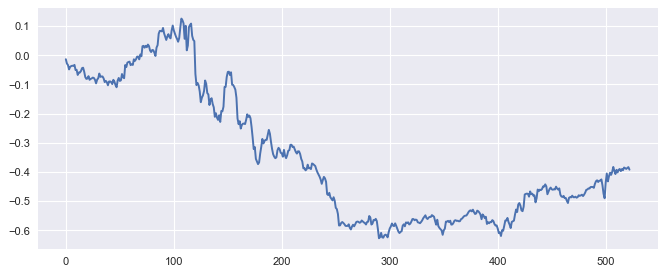

In [26]:
#Plotting some intersting strategy. 
from matplotlib.pyplot import figure
figure(figsize=(10, 4), dpi=80)
plt.plot(np.cumsum(trades_w_costs))
plt.show;

In [27]:
trades_w_costs[0:10]

[-0.013641999999999791,
 -0.014682000000000165,
 -0.005392000000000144,
 -0.014801999999999841,
 0.008657999999999973,
 0.002777999999999866,
 0.0011979999999999513,
 -0.00043199999999984695,
 0.003197999999999953,
 -0.017601999999999975]